# Description

Objective : To recommend optimum crops to be cultivated by farmers based on several parameters and help them make an informed decision before cultivation

Data Source : https://www.kaggle.com/datasets/chitrakumari25/smart-agricultural-production-optimizing-engine 


Credit:
Inspired by Atharva Ingle

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import tree
from __future__ import print_function
import pickle as pickle
from dateutil.parser import parse 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
import os
import sys
import pyodbc
import warnings
warnings.filterwarnings('ignore')

# Database connection to MSSQL Server

In [2]:
#================= Create Database Connection ======================#
engine = pyodbc.connect("DRIVER={SQL Server};"
                      "Server=192.168.37.128;"
                      "UID=sa;"
                      "PWD=Abc12345;"
                      "Database=PREDICTIVE;"
                      "Trusted_Connection=NO;")
cursor =engine.cursor()

pd.options.display.float_format = '{:,.2f}'.format

# Call Query from MSSQL Server

In [3]:
sql_query = """SELECT * FROM Crop_recommendation;""".format(input)
df = pd.read_sql_query(sql_query , engine)

df

,Nitrogen,Phosphorus,Pottasium,temperature,humidity,ph,rainfall,Crop
0,90,42,43,20.88,82.00,6.50,202.94,rice
1,85,58,41,21.77,80.32,7.04,226.66,rice
2,60,55,44,23.00,82.32,7.84,263.96,rice
3,74,35,40,26.49,80.16,6.98,242.86,rice
4,78,42,42,20.13,81.60,7.63,262.72,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.77,66.41,6.78,177.77,coffee
2196,99,15,27,27.42,56.64,6.09,127.92,coffee
2197,118,33,30,24.13,67.23,6.36,173.32,coffee
2198,117,32,34,26.27,52.13,6.76,127.18,coffee


In [4]:
df['Crop'].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: Crop, dtype: int64

# Descriptive statistics for each column

In [5]:
df.describe()

,Nitrogen,Phosphorus,Pottasium,temperature,humidity,ph,rainfall
count,"2,200.00","2,200.00","2,200.00","2,200.00","2,200.00","2,200.00","2,200.00"
mean,50.55,53.36,48.15,25.62,71.48,6.47,103.46
std,36.92,32.99,50.65,5.06,22.26,0.77,54.96
min,0.00,5.00,5.00,8.83,14.26,3.50,20.21
25%,21.00,28.00,20.00,22.77,60.26,5.97,64.55
50%,37.00,51.00,32.00,25.60,80.47,6.43,94.87
75%,84.25,68.00,49.00,28.56,89.95,6.92,124.27
max,140.00,145.00,205.00,43.68,99.98,9.94,298.56


# Correlation Heatmap

<AxesSubplot:>

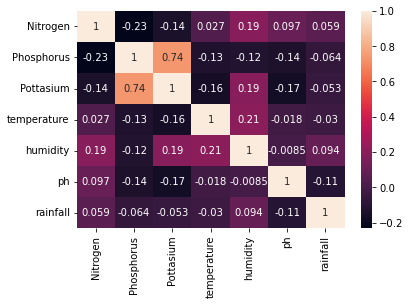

In [6]:
sns.heatmap(df.corr(),annot=True)

# Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Pottasium    2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [8]:
print('Dataframe size :',df.size)
print('Dataframe shape :',df.shape)
print('Dataframe features columns :' ,df.columns)
print('Dataframe target columns :', df['Crop'].unique())




Dataframe size : 17600
Dataframe shape : (2200, 8)
Dataframe features columns : Index(['Nitrogen', 'Phosphorus', 'Pottasium', 'temperature', 'humidity', 'ph',
       'rainfall', 'Crop'],
      dtype='object')
Dataframe target columns : ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In [9]:
# Checking the missing values
df.isnull().sum()

Nitrogen       0
Phosphorus     0
Pottasium      0
temperature    0
humidity       0
ph             0
rainfall       0
Crop           0
dtype: int64

# Seperating features (X-variable) and target (Y-variable) label

In [10]:
features = df[['Nitrogen', 'Phosphorus','Pottasium','temperature', 'humidity', 'ph', 'rainfall']]
target = df['Crop']
labels = df['Crop']

# Initializing empty lists to append all model's name and corresponding name

In [11]:
# Initializing empty lists to append all model's name and corresponding name
acc = []
model = []

# Splitting into train and test data

In [12]:
# Splitting into train and test data

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features,target,test_size = 0.2,random_state =2)

# Decision Tree Model

In [13]:
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(criterion="entropy",random_state=2,max_depth=5)

DecisionTree.fit(Xtrain,Ytrain)

# Predicting the target values of the test set
predicted_values = DecisionTree.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Decision Tree')
print("DecisionTrees's Accuracy is: ", x*100)

print(classification_report(Ytest,predicted_values))

DecisionTrees's Accuracy is:  90.0
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.59      1.00      0.74        16
    chickpea       1.00      1.00      1.00        21
     coconut       0.91      1.00      0.95        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.74      0.93      0.83        28
 kidneybeans       0.00      0.00      0.00        14
      lentil       0.68      1.00      0.81        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       0.00      0.00      0.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00   

In [14]:
from sklearn.model_selection import cross_val_score

In [15]:
# Cross validation score (Decision Tree)
score = cross_val_score(DecisionTree, features, target,cv=5)
print('Cross Validation Score :',score)

Cross Validation Score : [0.93636364 0.90909091 0.91818182 0.87045455 0.93636364]


# Saving trained Decision Tree model

In [16]:
import pickle
# Dump the trained Decision Tree classifier with Pickle
DT_pkl_filename = 'DecisionTree.pkl'
# Open the file to save as pkl file
DT_Model_pkl = open(DT_pkl_filename, 'wb')
pickle.dump(DecisionTree, DT_Model_pkl)
# Close the pickle instances
DT_Model_pkl.close()

# Guassian Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB

NaiveBayes = GaussianNB()

NaiveBayes.fit(Xtrain,Ytrain)

predicted_values = NaiveBayes.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Naive Bayes')
print("Naive Bayes's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

Naive Bayes's Accuracy is:  0.990909090909091
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00  

In [18]:
# Cross validation score (NaiveBayes)
score = cross_val_score(NaiveBayes,features,target,cv=5)
print('Cross Validation Score :',score)

Cross Validation Score : [0.99772727 0.99545455 0.99545455 0.99545455 0.99090909]


# Saving trained Guassian Naive Bayes model

In [19]:
import pickle
# Dump the trained Naive Bayes classifier with Pickle
NB_pkl_filename = 'NBClassifier.pkl'
# Open the file to save as pkl file
NB_Model_pkl = open(NB_pkl_filename, 'wb')
pickle.dump(NaiveBayes, NB_Model_pkl)
# Close the pickle instances
NB_Model_pkl.close()

# Support Vector Machine (SVM)

In [20]:
from sklearn.svm import SVC

SVM = SVC(gamma='auto')

SVM.fit(Xtrain,Ytrain)

predicted_values = SVM.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('SVM')
print("SVM's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

SVM's Accuracy is:  0.10681818181818181
              precision    recall  f1-score   support

       apple       1.00      0.23      0.38        13
      banana       1.00      0.24      0.38        17
   blackgram       1.00      0.19      0.32        16
    chickpea       1.00      0.05      0.09        21
     coconut       1.00      0.05      0.09        21
      coffee       0.00      0.00      0.00        22
      cotton       1.00      0.05      0.10        20
      grapes       1.00      0.06      0.11        18
        jute       1.00      0.07      0.13        28
 kidneybeans       0.03      1.00      0.07        14
      lentil       0.00      0.00      0.00        23
       maize       0.00      0.00      0.00        21
       mango       0.00      0.00      0.00        26
   mothbeans       0.00      0.00      0.00        19
    mungbean       1.00      0.12      0.22        24
   muskmelon       1.00      0.30      0.47        23
      orange       1.00      0.03      0.

In [21]:
# Cross validation score (SVM)
score = cross_val_score(SVM,features,target,cv=5)
print('Cross Validation Score :',score)

Cross Validation Score : [0.27727273 0.28863636 0.29090909 0.275      0.26818182]


# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(random_state=2)

LogReg.fit(Xtrain,Ytrain)

predicted_values = LogReg.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Logistic Regression')
print("Logistic Regression's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

Logistic Regression's Accuracy is:  0.9522727272727273
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.86      0.75      0.80        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       0.86      0.90      0.88        20
      grapes       1.00      1.00      1.00        18
        jute       0.84      0.93      0.88        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       0.88      1.00      0.94        23
       maize       0.90      0.86      0.88        21
       mango       0.96      1.00      0.98        26
   mothbeans       0.84      0.84      0.84        19
    mungbean       1.00      0.96      0.98        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00   

In [23]:
# Cross validation score (Logistic Regression)
score = cross_val_score(LogReg,features,target,cv=5)
print('Cross Validation Score :',score)

Cross Validation Score : [0.95       0.96590909 0.94772727 0.96818182 0.94318182]


# Saving trained Logistic Regression model

In [24]:
import pickle
# Dump the trained Logistic Regression with Pickle
LR_pkl_filename = 'LogisticRegression.pkl'
# Open the file to save as pkl file
LR_Model_pkl = open(LR_pkl_filename, 'wb')
pickle.dump(LogReg, LR_Model_pkl)
# Close the pickle instances
LR_Model_pkl.close()

# Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=20, random_state=0)
RF.fit(Xtrain,Ytrain)

predicted_values = RF.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('RF')
print("RF's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

RF's Accuracy is:  0.990909090909091
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.94      1.00      0.97        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.90      1.00      0.95        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      0.95      0.97        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00 

In [26]:
# Cross validation score (Random Forest)
score = cross_val_score(RF,features,target,cv=5)
print('Cross Validation Score :',score)

Cross Validation Score : [0.99772727 0.99545455 0.99772727 0.99318182 0.98863636]


# Saving trained Random Forest model

In [27]:
import pickle
# Dump the trained Random Forest classifier with Pickle
RF_pkl_filename = 'RandomForest.pkl'
# Open the file to save as pkl file
RF_Model_pkl = open(RF_pkl_filename, 'wb')
pickle.dump(RF, RF_Model_pkl)
# Close the pickle instances
RF_Model_pkl.close()

# Accuracy Comparison

<AxesSubplot:title={'center':'Accuracy Comparison'}, xlabel='Accuracy', ylabel='Algorithm'>

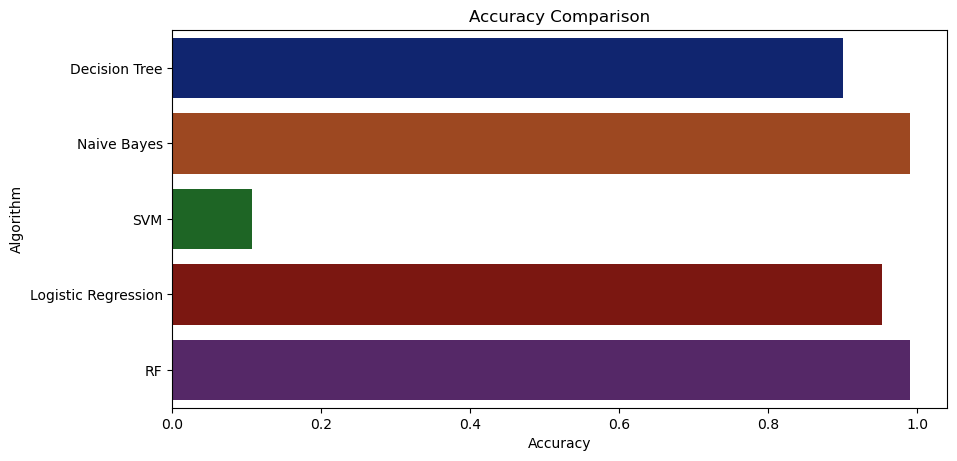

In [28]:
plt.figure(figsize=[10,5],dpi = 100)
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x = acc,y = model,palette='dark')

In [30]:
accuracy_models = dict(zip(model, acc))
for k, v in accuracy_models.items():
    print (k, '=', v)

Decision Tree = 0.9
Naive Bayes = 0.990909090909091
SVM = 0.10681818181818181
Logistic Regression = 0.9522727272727273
RF = 0.990909090909091
